In [24]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
%autoreload 2
from collections import defaultdict
from datetime import datetime
import h5py
import matplotlib.pyplot as plt
from neural_analysis.matIO import loadmat
import numpy as np
import os
import pandas as pd
from scipy.signal import butter, filtfilt, freqz
import sys
import time
from tqdm.auto import tqdm

sys.path.append('../..')
from ld_utils import compute_eigs, get_data_sigma_norms
from up_down import get_up_down
from utils import get_binary_stimuli, get_sample_interval, load, save, to_string

## Load Neural Data

In [26]:
# filename = '../../__data__/Mary-Anesthesia-20160809-01.mat'
# filename = r'/home/adameisen/millerdata/common/datasets/anesthesia/mat/propofolPuffTone/Mary-Anesthesia-20160809-01.mat'
# filename = r'/home/adameisen/millerdata/common/datasets/anesthesia/mat/propofolPuffTone/MrJones-Anesthesia-20160121-01.mat'
# filename = r'/home/adameisen/common/datasets/anesthesia/mat/propofolWakeUp/Mary-Anesthesia-20170203-02.mat'
# filename = r'/home/adameisen/millerdata/common/datasets/anesthesia/mat/ketamine/Mary-Anesthesia-20170315-01.mat'
filename = r'/home/adameisen/millerdata/common/datasets/anesthesia/mat/ketamine/Mary-Anesthesia-20170329-02.mat'

print("Loading data ...")
start = time.process_time()
# electrode_info, lfp, lfp_schema, session_info, spike_times, trial_info, unit_info = loadmat(filename, variables=['electrodeInfo', 'lfp', 'lfpSchema', 'sessionInfo', 'spikeTimes', 'trialInfo', 'unitInfo'], verbose=False)
electrode_info, lfp_schema, session_info, spike_times, trial_info, unit_info = loadmat(filename, variables=['electrodeInfo', 'lfpSchema', 'sessionInfo', 'spikeTimes', 'trialInfo', 'unitInfo'], verbose=False)
spike_times = spike_times[0]
dt = lfp_schema['smpInterval'][0]
T = lfp.shape[0]

f = h5py.File(filename, 'r')
# airPuff_binary, audio_binary = get_binary_stimuli(f)

print(f"Data loaded (took {time.process_time() - start:.2f} seconds)")

Loading data ...
Data loaded (took 4.13 seconds)


# VAR

In [23]:
data_path = "../../__data__/VAR/ketamine"
os.makedirs(data_path, exist_ok=True)
# areas = np.unique(electrode_info['area'])
# areas = ['vlPFC']
# unit_indices = np.arange(lfp.shape[1])[pd.Series(electrode_info['area']).isin(areas)]
PCA_dim = -1
end_step = T - int(30/dt) # take off 30 seconds
# end_step = 5000
for window in [2.5]:
# for window in [0.15, 0.25, 0.5, 1, 2.5, 5]:
    stride = window
    results = {}
    
    for area in np.unique(electrode_info['area']):
        areas = [area]
        unit_indices = np.arange(lfp.shape[1])[pd.Series(electrode_info['area']).isin(areas)]

        data = lfp[:end_step, unit_indices]
        print(f"window = {window}, area = {area}")
        results[area] = compute_eigs(data, dt, window, stride, return_sigma_norms=True, PCA_dim=PCA_dim, verbose=True)
        results[area]['end_step'] = end_step
        results[area]['data_sigma_norms'] = get_data_sigma_norms(data, dt, window, stride)
        del data
    
    print(f"window = {window}, all areas")
    areas = np.unique(electrode_info['area'])
    unit_indices = np.arange(lfp.shape[1])[pd.Series(electrode_info['area']).isin(areas)]
    data = lfp[:end_step, unit_indices]
    results['all'] = compute_eigs(data, dt, window, stride, return_sigma_norms=True, PCA_dim=PCA_dim, verbose=True, return_A=True)
    results['all']['end_step'] = end_step
    results['all']['data_sigma_norms'] = get_data_sigma_norms(data, dt, window, stride)
    del data
    
    save(results, os.path.join(data_path, f"results_ketamine_{os.path.basename(filename)[:-4]}_window_{window}_stride_{stride}_PCA_dim_{PCA_dim}"))

window = 2.5, area = 7b


  0%|          | 0/2492 [00:00<?, ?it/s]

window = 2.5, area = CPB


  0%|          | 0/2492 [00:00<?, ?it/s]

window = 2.5, area = FEF


  0%|          | 0/2492 [00:00<?, ?it/s]

window = 2.5, area = Thal


  0%|          | 0/2492 [00:00<?, ?it/s]

window = 2.5, area = vlPFC


  0%|          | 0/2492 [00:00<?, ?it/s]

window = 2.5, all areas


  0%|          | 0/2492 [00:00<?, ?it/s]

# Area Analysis

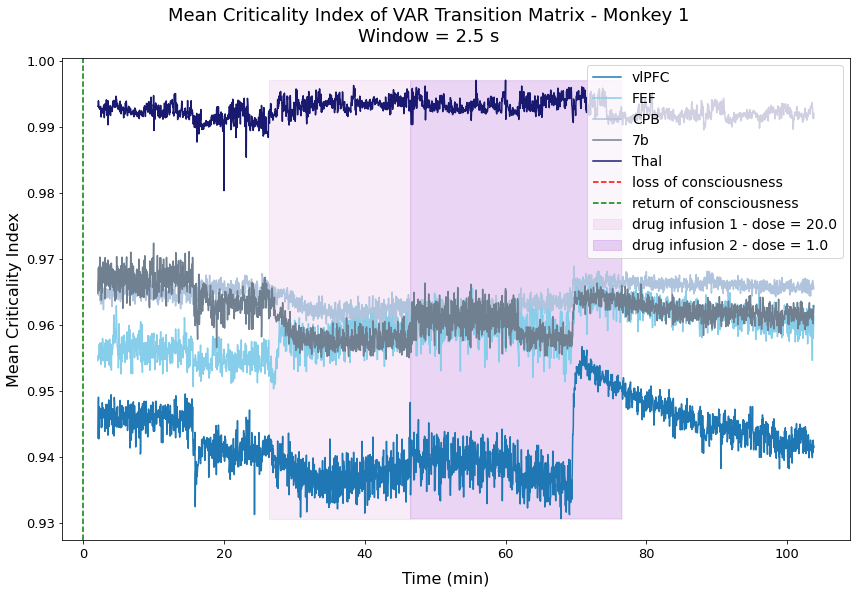

In [17]:
fig = plt.figure(figsize=(12, 8))
ax = plt.gca()

window = 2.5
stride = window
data_path = "../../__data__/VAR/ketamine"
results = load(os.path.join(data_path, f'results_ketamine_{os.path.basename(filename)[:-4]}_window_{window}_stride_{stride}_PCA_dim_-1'))

min_val = np.Inf
max_val = -np.Inf
# for area, c in [('vlPFC', 'C0'), ('FEF', 'skyblue'), ('CPB', 'lightsteelblue'), ('7b', 'slategray')]:
for area, c in [('vlPFC', 'C0'), ('FEF', 'skyblue'), ('CPB', 'lightsteelblue'), ('7b', 'slategray'), ('Thal', 'midnightblue')]:
# for area, c in [('vlPFC', 'C0')]:
    start_times = np.arange(results[area]['eigs'].shape[0])*stride/60
    criticality_inds = results[area]['eigs'].mean(axis=1)
    start_ind = 50
    start_times = start_times[start_ind:]
    criticality_inds = criticality_inds[start_ind:]
    ax.plot(start_times, criticality_inds, label=area, c=c)
    
    if criticality_inds.min() < min_val:
        min_val = criticality_inds.min()
    if criticality_inds.max() > max_val:
        max_val = criticality_inds.max()

# min_val = criticality_inds.min()
# max_val = criticality_inds.max()
ax.fill_between(np.arange(session_info['drugStart'][0], session_info['drugEnd'][0], stride)/60, 
                                min_val, max_val, color='plum', alpha=0.2, label=f"drug infusion 1 - dose = {session_info['drugDose'][0]}")
ax.fill_between(np.arange(session_info['drugStart'][1], session_info['drugEnd'][1], stride)/60, 
                        min_val, max_val, color='darkorchid', alpha=0.2, label=f"drug infusion 2 - dose = {session_info['drugDose'][1]}")

plt.axvline(session_info['eyesClose'][-1]/60 if isinstance(session_info['eyesClose'], np.ndarray) else session_info['eyesClose']/60, linestyle='--', c='red', label="loss of consciousness")
plt.axvline(session_info['eyesOpen'][-1]/60 if isinstance(session_info['eyesOpen'], np.ndarray) else session_info['eyesOpen']/60, linestyle='--', c='green', label="return of consciousness")
ax.legend(fontsize=14)        
fig.text(0.52, -0.02, 'Time (min)', ha='center', fontsize=16)
ax.set_ylabel('Mean Criticality Index', fontsize=16)
ax.tick_params(labelsize=13)
plt.suptitle("Mean Criticality Index of VAR Transition Matrix - Monkey 1\nWindow = 2.5 s", fontsize=18)
plt.tight_layout()
plt.show()

# Multipop Analysis

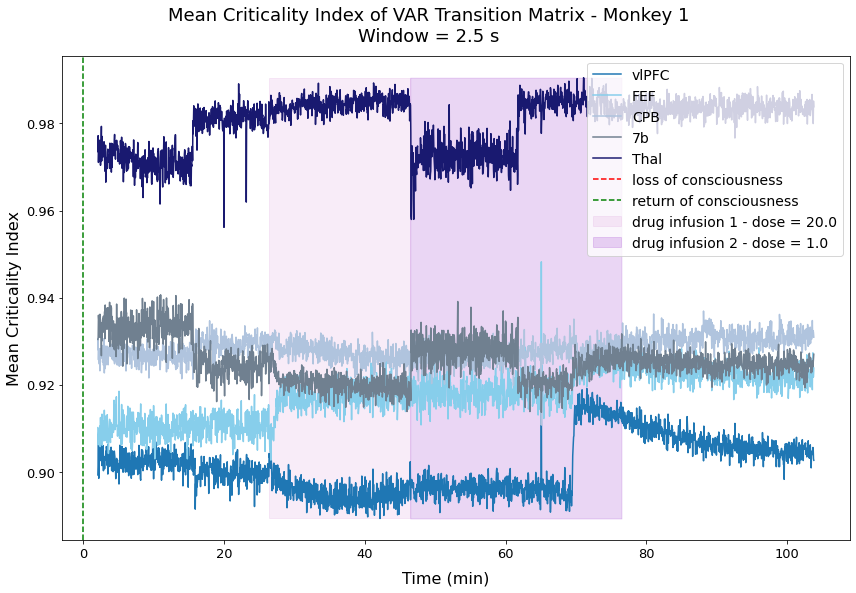

In [27]:
fig = plt.figure(figsize=(12, 8))
ax = plt.gca()

window = 2.5
stride = window
data_path = "../../__data__/VAR/ketamine"
# results = load(os.path.join(data_path, f'results_ketamine_{os.path.basename(filename)[:-4]}_window_{window}_stride_{stride}_PCA_dim_{PCA_dim}'))

min_val = np.Inf
max_val = -np.Inf
for area, c in [('vlPFC', 'C0'), ('FEF', 'skyblue'), ('CPB', 'lightsteelblue'), ('7b', 'slategray'), ('Thal', 'midnightblue')]:
# for area, c in [('vlPFC', 'C0')]:
    start_times = np.arange(results['all']['eigs'].shape[0])*stride/60
    
    areas = [area]
    unit_indices = np.arange(lfp.shape[1])[pd.Series(electrode_info['area']).isin(areas)]
    
    criticality_inds = np.zeros(results['all']['A_mats'].shape[0])
    for i in range(len(criticality_inds)):
        e, _ = np.linalg.eig(results['all']['A_mats'][i][unit_indices][:, unit_indices])
        criticality_inds[i] = np.abs(e).mean()
    
#     criticality_inds = results[area]['eigs'].mean(axis=1)
    start_ind = 50
    start_times = start_times[start_ind:]
    criticality_inds = criticality_inds[start_ind:]
    ax.plot(start_times, criticality_inds, label=area, c=c)
    
    if criticality_inds.min() < min_val:
        min_val = criticality_inds.min()
    if criticality_inds.max() > max_val:
        max_val = criticality_inds.max()

# min_val = criticality_inds.min()
# max_val = criticality_inds.max()
ax.fill_between(np.arange(session_info['drugStart'][0], session_info['drugEnd'][0], stride)/60, 
                                min_val, max_val, color='plum', alpha=0.2, label=f"drug infusion 1 - dose = {session_info['drugDose'][0]}")
ax.fill_between(np.arange(session_info['drugStart'][1], session_info['drugEnd'][1], stride)/60, 
                        min_val, max_val, color='darkorchid', alpha=0.2, label=f"drug infusion 2 - dose = {session_info['drugDose'][1]}")

plt.axvline(session_info['eyesClose'][-1]/60 if isinstance(session_info['eyesClose'], np.ndarray) else session_info['eyesClose']/60, linestyle='--', c='red', label="loss of consciousness")
plt.axvline(session_info['eyesOpen'][-1]/60 if isinstance(session_info['eyesOpen'], np.ndarray) else session_info['eyesOpen']/60, linestyle='--', c='green', label="return of consciousness")
ax.legend(fontsize=14)        
fig.text(0.52, -0.02, 'Time (min)', ha='center', fontsize=16)
ax.set_ylabel('Mean Criticality Index', fontsize=16)
ax.tick_params(labelsize=13)
plt.suptitle("Mean Criticality Index of VAR Transition Matrix - Monkey 1\nWindow = 2.5 s", fontsize=18)
plt.tight_layout()
plt.show()